### Anomaly Detection

In this notebook, you get a baseline for anomaly detection.

<img src="https://box.hu-berlin.de/f/53a91798173c4dad9345/?dl=1" width=800/>


### Required Libraries

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import plotly.graph_objects as go
import os
import fnmatch
import zipfile

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

### Utility functions

In [29]:
def read_series(path, file, locations=None):   
    print (path + "/"+ file)
    data = pd.read_csv(path + "/"+ file, header=None)
    data = np.array(data).flatten()
    
    # Extract file name
    file_name = file.split('.')[0]
    splits = file_name.split('_')
    test_start = np.array(splits[-1])

    # load the anomalies
    if locations is None:
        locations = pd.read_csv("phase_1/labels.csv")
        locations.set_index("Name", inplace=True)

    # Extract anomaly location
    anomaly = [-1, -1]
    if file_name in locations.index:
        row = locations.loc[file_name]
        anomaly = row["Pos"]

    return (file_name, int(test_start), data, anomaly)


def find_dominant_window_sizes(ts, n_size=1):
    fourier = np.absolute(np.fft.fft(ts))
    freq = np.fft.fftfreq(ts.shape[0], 1)
    coefs = []
    window_sizes = []
    for coef, freq in zip(fourier, freq):
        if coef > 0 and freq > 0 and freq < 0.2:
            window_size = 1.0 / freq
            # avoid too large windows
            if (window_size < 500) and (window_size > 10):
                coefs.append(coef)
                window_sizes.append(window_size)
    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)
    idx = np.argsort(coefs)[::-1]
    
    unique_window_sizes = set()
    for window_size in window_sizes[idx]:
        if len(unique_window_sizes) == n_size:
            return np.array([w for w in unique_window_sizes])
        unique_window_sizes.add(window_size)
    return np.array(list(unique_window_sizes))


def sliding_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def visualize_with_anomaly_score(
        data, score, test_start, 
        predicted, anomaly, name = None
        ):
    '''Input:
       data: array with the raw data
       test_start: the offset where the test data starts
       predicted: The offset of your prediction.
       anomaly: The offset of the anomaly. 
                      If -1 is passed, no anomaly is plottet.
    '''
    
    anomaly_start = anomaly - 50    
    anomaly_end = anomaly + 50
    predicted_start = predicted - 50
    predicted_end = predicted + 50
    
    fig, ax = plt.subplots(2,1, figsize=(20, 4), sharex=True)
    sns.lineplot(x=np.arange(test_start, len(data)), y=data[test_start:], ax = ax[0], lw=0.5, label="Test")
    sns.lineplot(x=np.arange(0, test_start), y=data[:test_start], ax = ax[0], lw=0.5, label="Train")
        
    if (anomaly_start > 0):
        sns.lineplot(x=np.arange(anomaly_start, anomaly_end), 
                     y=data[anomaly_start:anomaly_end], ax = ax[0], label="Actual")
    
    sns.lineplot(x=np.arange(len(score)), y=score, ax = ax[1], label="Anomaly Scores")
    sns.lineplot(x=np.arange(predicted_start, predicted_end), 
                 y=data[predicted_start:predicted_end], ax = ax[0], label="Predicted")

    if name is not None:
        ax[0].set_title(name)
        
    sns.despine()
    
    #################
    
    plt.legend()
    plt.show()

<hr/>

# Baseline: Anomaly Detection using Predictive Modelling

You are now given an algorithm that computes an anomaly score for each time series:

<img src="https://box.hu-berlin.de/f/2812ccfbcae24e318f9e/?dl=1" width=800/>

The score's maximum indicates where the anomaly is.

phase_1/000_Anomaly_2500.csv


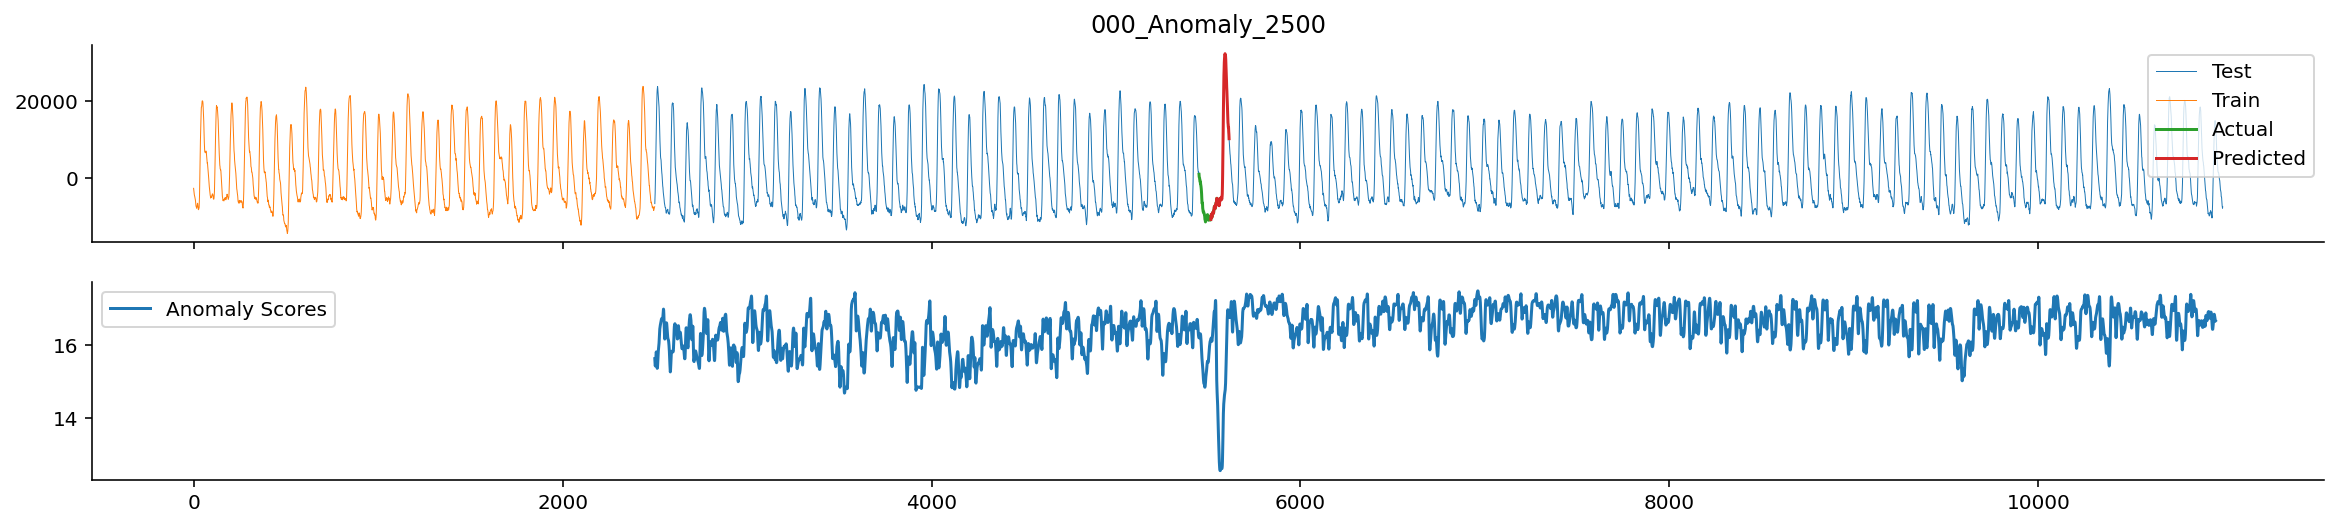

Current Score:  1.1636363636363636
phase_1/001_Anomaly_4000.csv


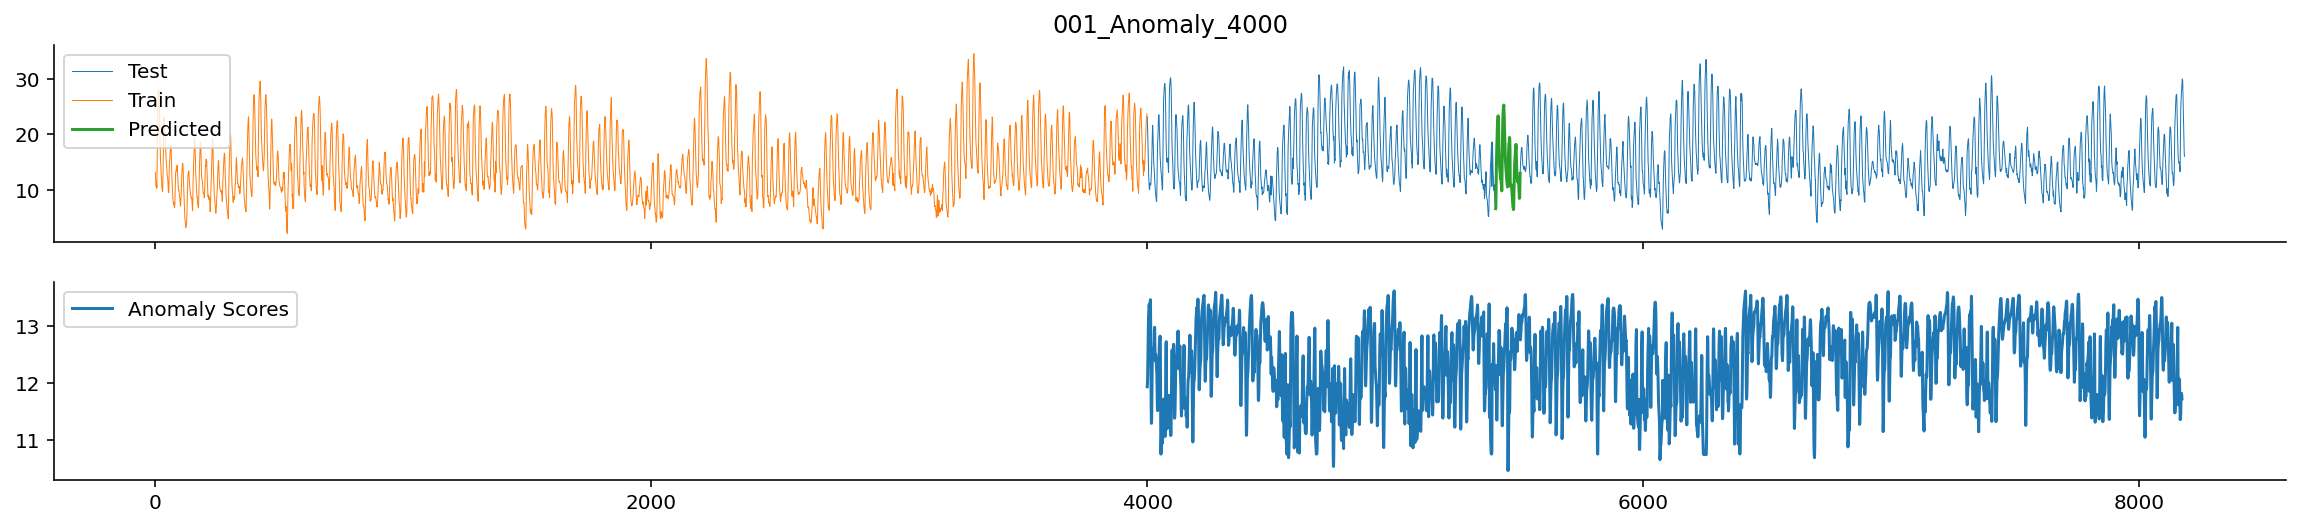

Current Score:  1.1636363636363636
phase_1/002_Anomaly_4000.csv


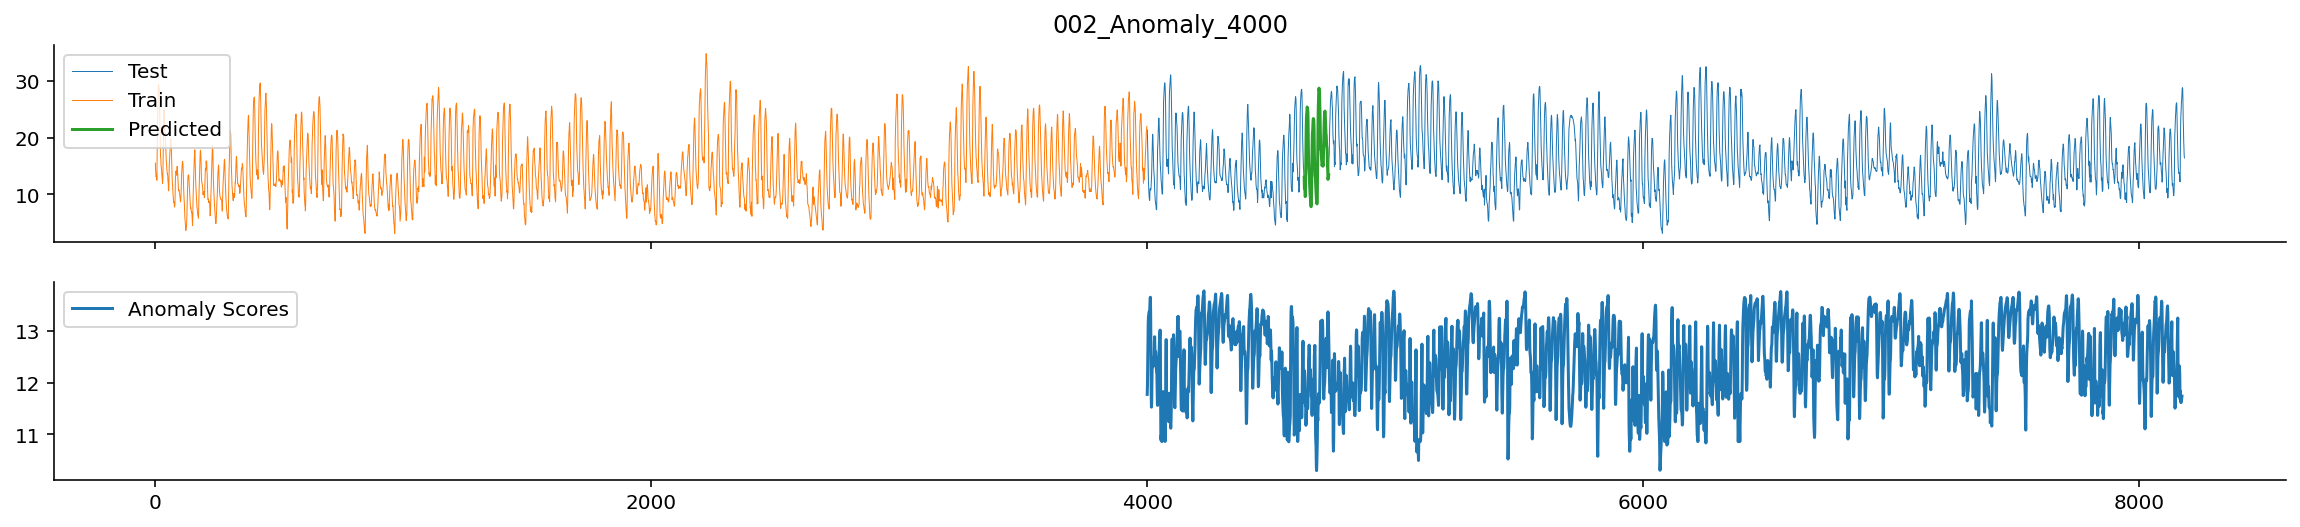

Current Score:  1.1636363636363636
phase_1/003_Anomaly_4000.csv


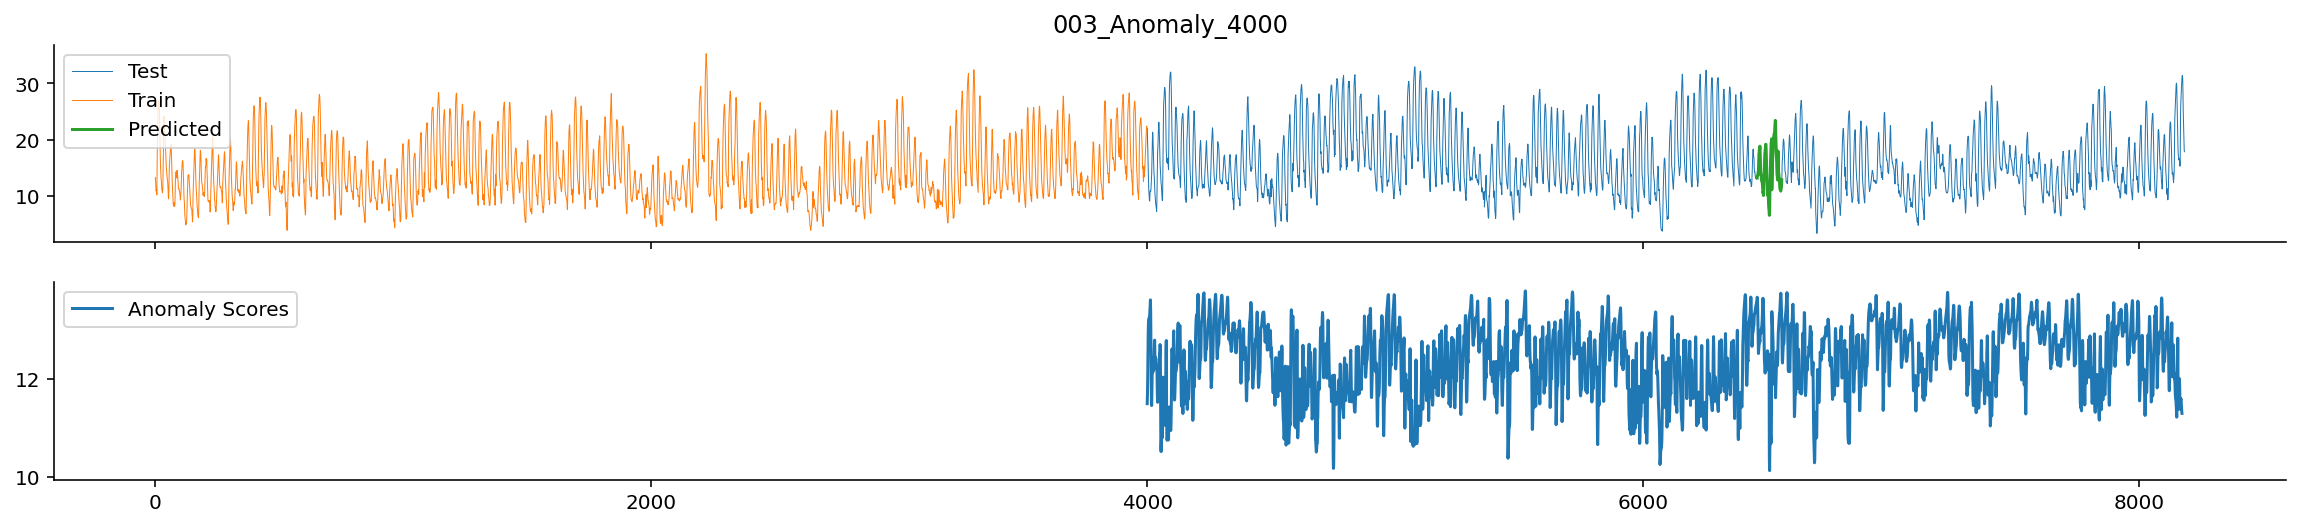

Current Score:  1.1636363636363636
phase_1/004_Anomaly_4000.csv


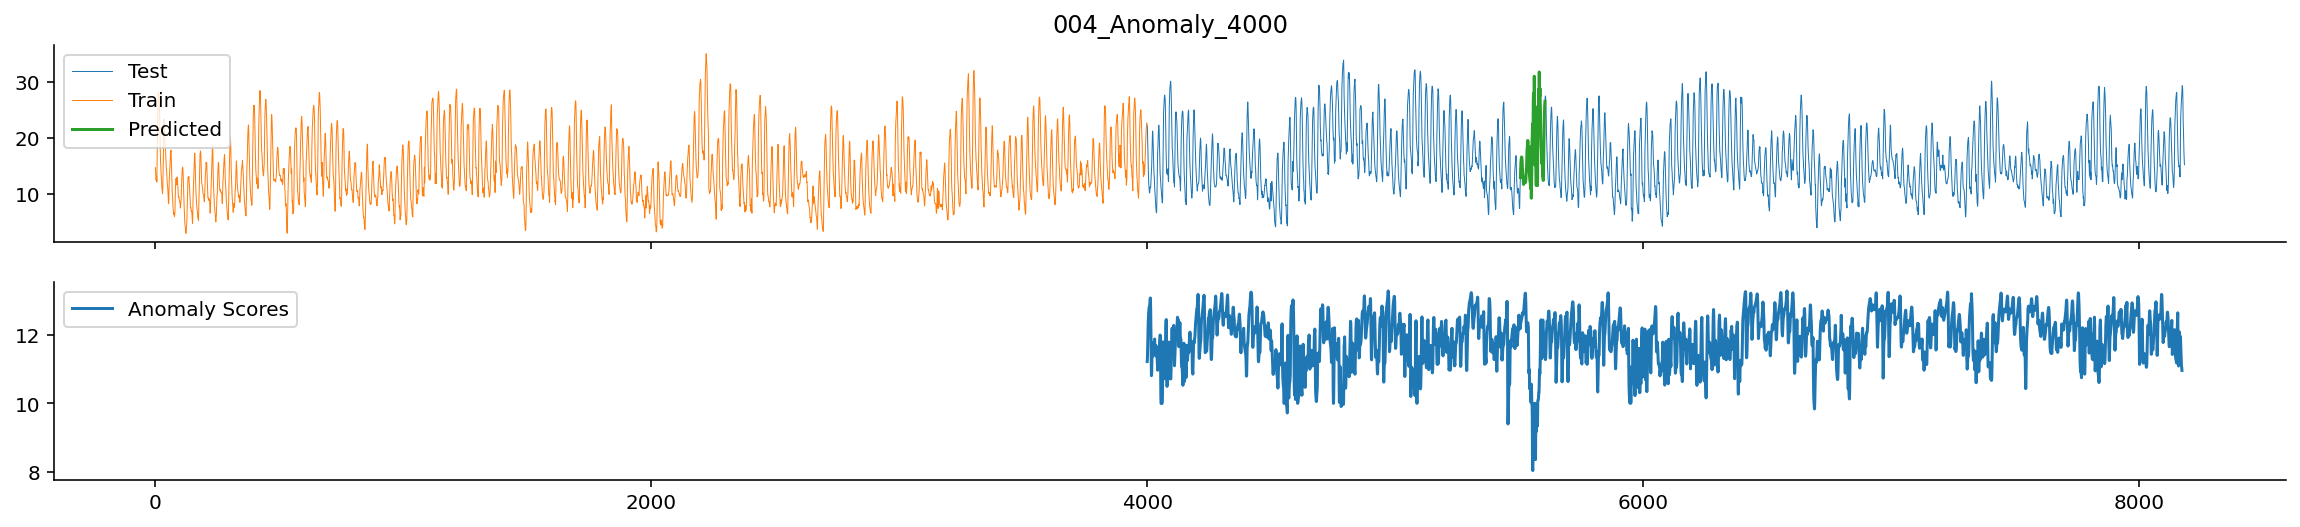

Current Score:  1.1636363636363636
phase_1/005_Anomaly_4000.csv


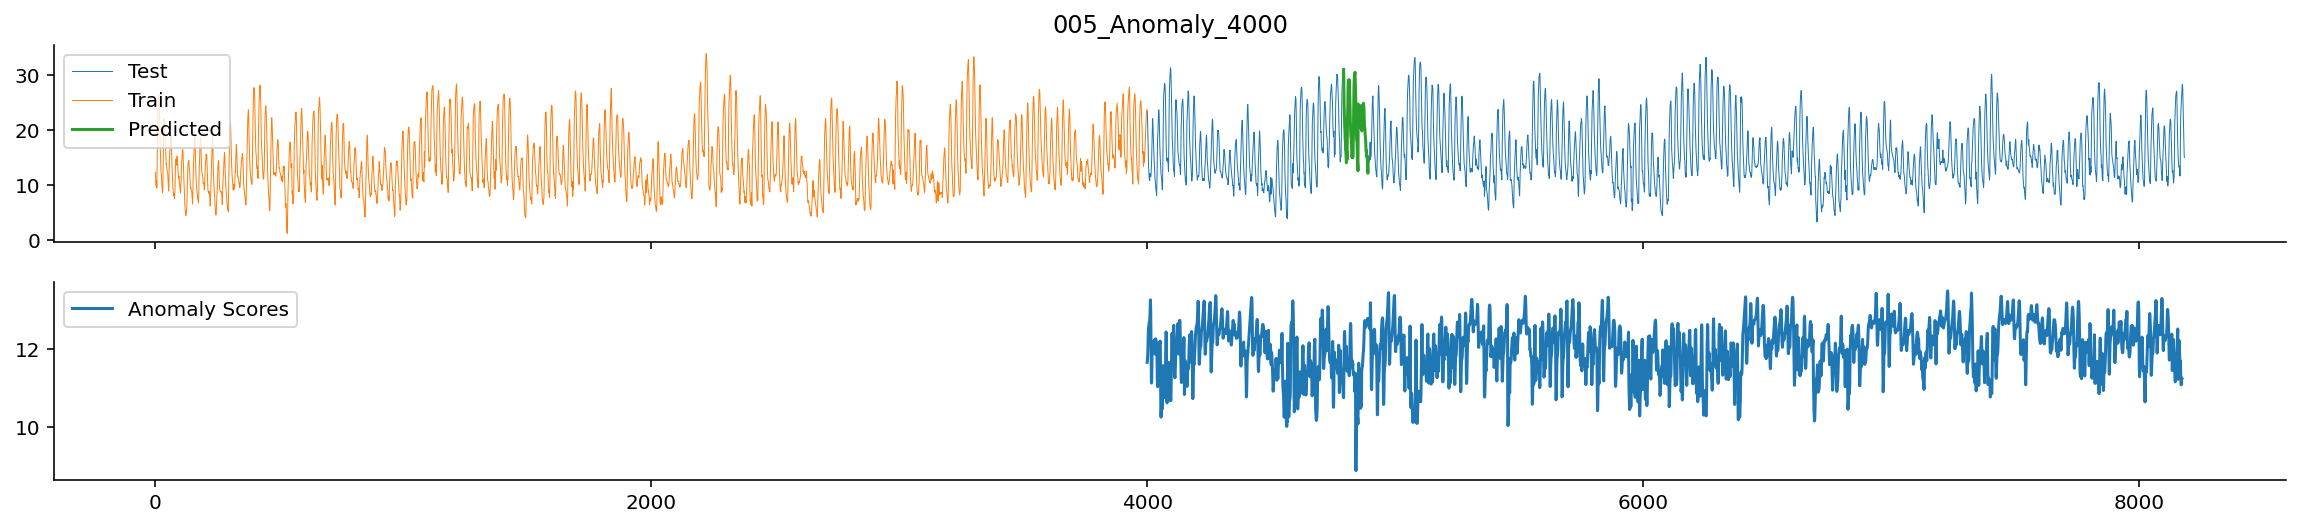

Current Score:  1.1636363636363636
phase_1/006_Anomaly_4000.csv


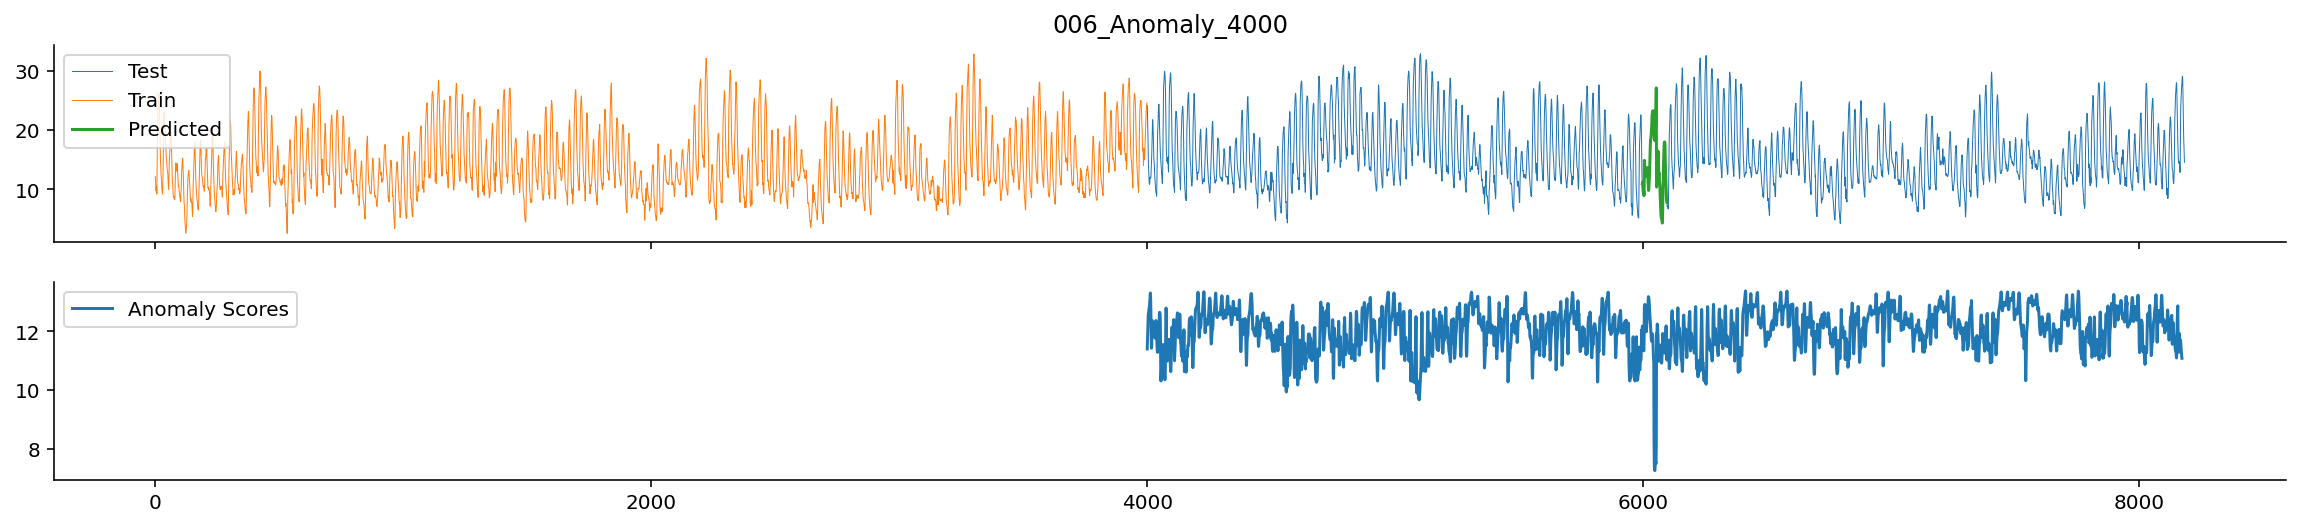

Current Score:  1.1636363636363636
phase_1/007_Anomaly_3333.csv


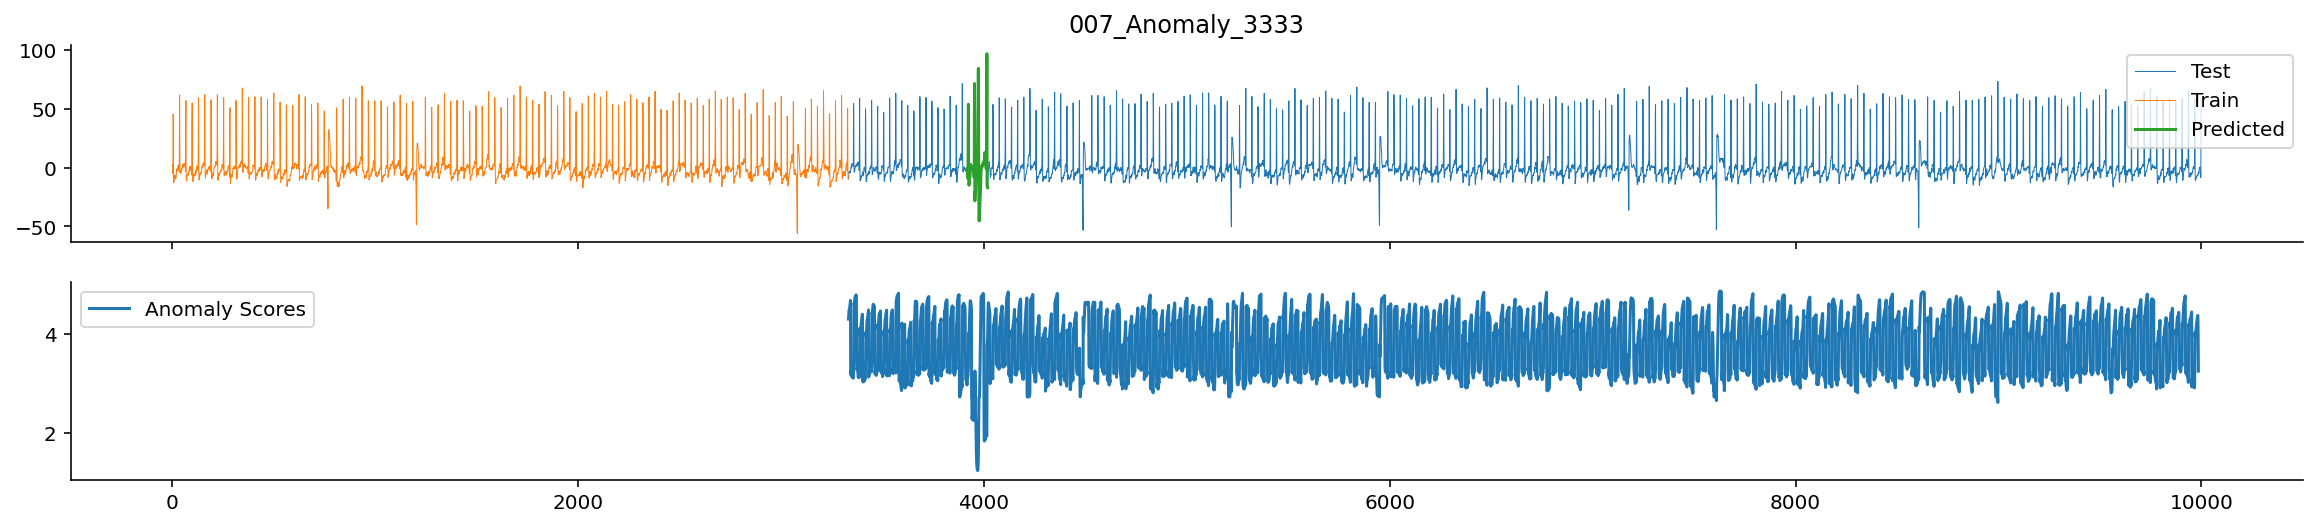

Current Score:  1.1636363636363636
phase_1/008_Anomaly_5000.csv


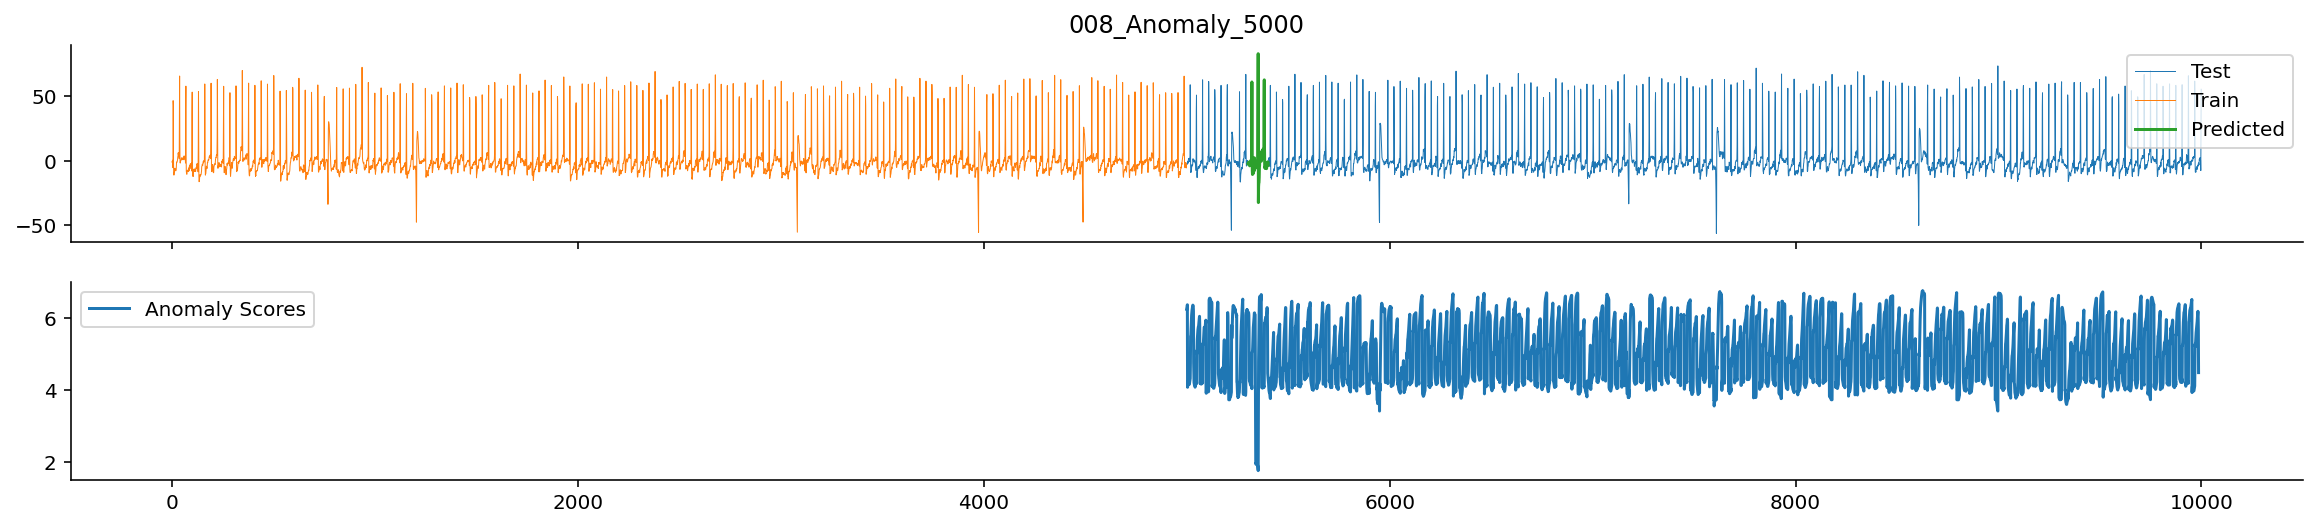

Current Score:  1.1636363636363636
phase_1/009_Anomaly_5000.csv


KeyboardInterrupt: 

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

locations = pd.read_csv("phase_1/labels.csv")
locations.set_index("Name", inplace=True)
anomalie_files = "phase_1"

total_score = 0
predictions = []
ids = []
i = 0

for file in np.sort(fnmatch.filter(os.listdir(anomalie_files), "*.csv")):
    if "Anomaly" in str(file):
        file_name = file.split('.')[0]
        name, test_start, data, anomaly = read_series(anomalie_files, file, locations)

        periods = find_dominant_window_sizes(data[:test_start])
        window_size = np.int32(periods[0] / 2)
        X = sliding_window(data, window_size)

        #clf = LocalOutlierFactor(n_neighbors=5, metric='l2', n_jobs=-1)
        #clf.fit_predict(X)    
        #score = clf.negative_outlier_factor_

        clf = OneClassSVM(nu = 0.01).fit(X)
        score = clf.score_samples(X)

        #clf = IsolationForest().fit(X)
        #score = clf.score_samples(X)
    
        predicted = test_start + np.argmin(score[test_start:])
        predictions.append(predicted)
        ids.append(file_name)
        
        score[:test_start] = np.NaN

        # Visualize the predicted anomaly
        visualize_with_anomaly_score(
            data, score, test_start, predicted, anomaly, name)

        if (anomaly > -1):
            total_score += abs(anomaly - predicted) / (anomaly)        
            i = i+1
            
        print("Current Score: ", (total_score / i) * 100)

        
print("\tTotal score:", (total_score / 30) * 100)

# Submit your solution to Kaggle

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
Create a submission named `submission.csv` using your model and upload it to kaggle:
    
https://www.kaggle.com/c/time-series-anomaly-detection
</div>

In [ ]:
# Create a submission
submission = pd.DataFrame({'ID': ids,'PREDICTED': predictions})

#Visualize the first 5 rows
display(submission)

In [ ]:
filename = 'baseline_submission.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)